In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
import uproot as ur
import matplotlib.colors as mcolors
import numpy as np

In [2]:
data_df = pd.read_pickle("1-63-60-beam_DF.pkl")
sim_df = pd.read_pickle("Sim_e+3.3_DF.pkl")

hit_threshold = 1.0

In [3]:
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

def event_energy(data_df, threshold=0.5):
    filtered_df = data_df[data_df['energy_MIP'] > threshold]
    energy_sum = filtered_df.groupby('event')['energy_MIP'].sum()
    return energy_sum.values
    
def layer_energy(data_df, layer, threshold=0.5):
    # Filter by energy threshold and layer
    filtered_df = data_df[(data_df['energy_MIP'] > threshold) & (data_df['layer'] == layer)]

    # Group by 'event' and sum 'energy_MIP'
    energy_sum = filtered_df.groupby('event')['energy_MIP'].sum()

    # Return just the values as a NumPy array
    return energy_sum.values

In [4]:
def filter_event_energy(data_df, event_energy_threshold, hit_threshold=0.5):
    # Step 1: Filter hits above the hit energy threshold
    filtered_hits = data_df[data_df['energy_MIP'] > hit_threshold]

    # Step 2: Sum energy per event
    event_energy_sum = (
        filtered_hits.groupby('event')['energy_MIP']
        .sum()
        .reset_index(name='total_energy')
    )

    # Step 3: Keep only events with total energy above the event_energy_threshold
    selected_events = event_energy_sum[event_energy_sum['total_energy'] > event_energy_threshold]['event']

    # Step 4: Filter original data to include only selected events
    filtered_df = data_df[data_df['event'].isin(selected_events)]

    return filtered_df
    
data_df = filter_event_energy(data_df, 25)
sim_df = filter_event_energy(sim_df, 25)

<Figure size 640x480 with 0 Axes>

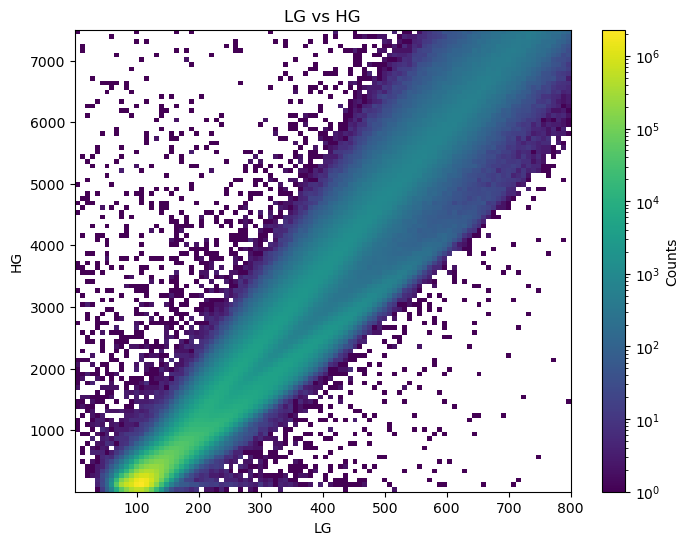

In [5]:
plt.figure(figsize=(8, 6))
plt.hist2d(data_df['LG'], data_df['HG'], bins=100, range=[(0.1, 800), (0.1, 7500)], cmap='viridis', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('LG')
plt.ylabel('HG')
plt.title('LG vs HG')
plt.show()

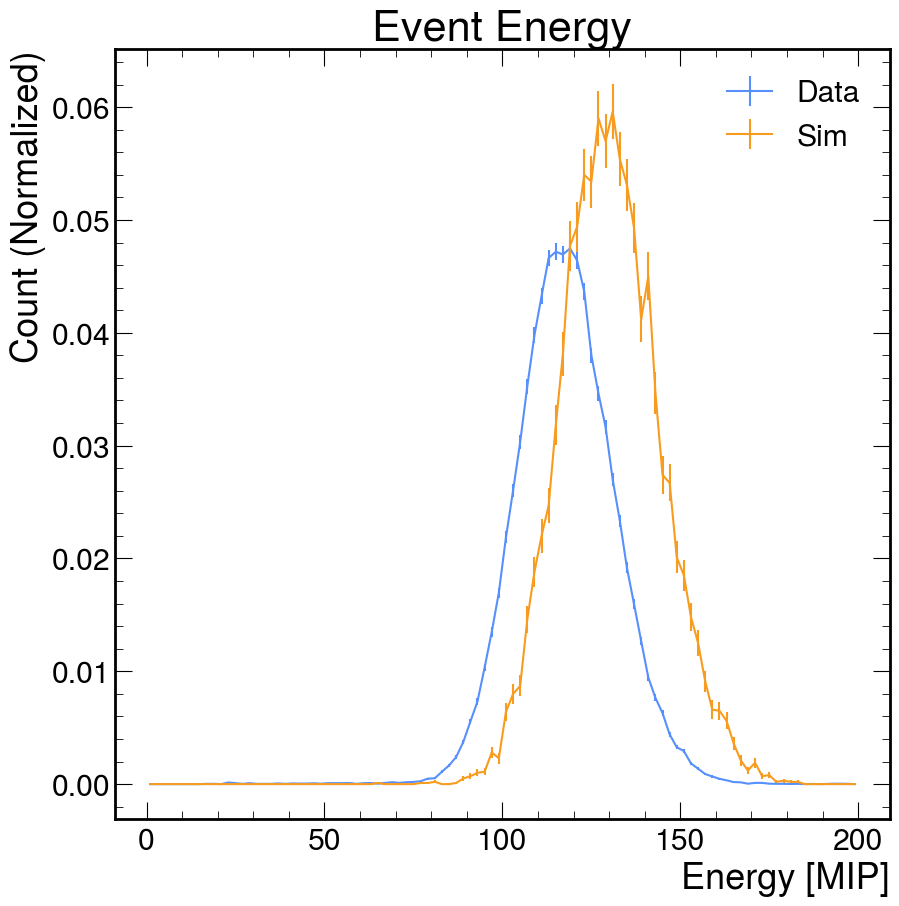

In [6]:
configure_plotting()

evt_energy = event_energy(data_df, hit_threshold)
counts, bin_edges = np.histogram(evt_energy, bins=100, range=[0, 200])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
counts = counts/len(evt_energy)
errors = errors/len(evt_energy)
plt.errorbar(bin_centers, counts, yerr=errors, fmt='-', label="Data")

evt_energy = event_energy(sim_df, hit_threshold)
counts, bin_edges = np.histogram(evt_energy, bins=100, range=[0, 200])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
counts = counts/len(evt_energy)
errors = errors/len(evt_energy)
plt.errorbar(bin_centers, counts, yerr=errors, fmt='-', label="Sim")
plt.legend()
plt.title("Event Energy")
plt.xlabel("Energy [MIP]")
plt.ylabel("Count (Normalized)")
plt.show()

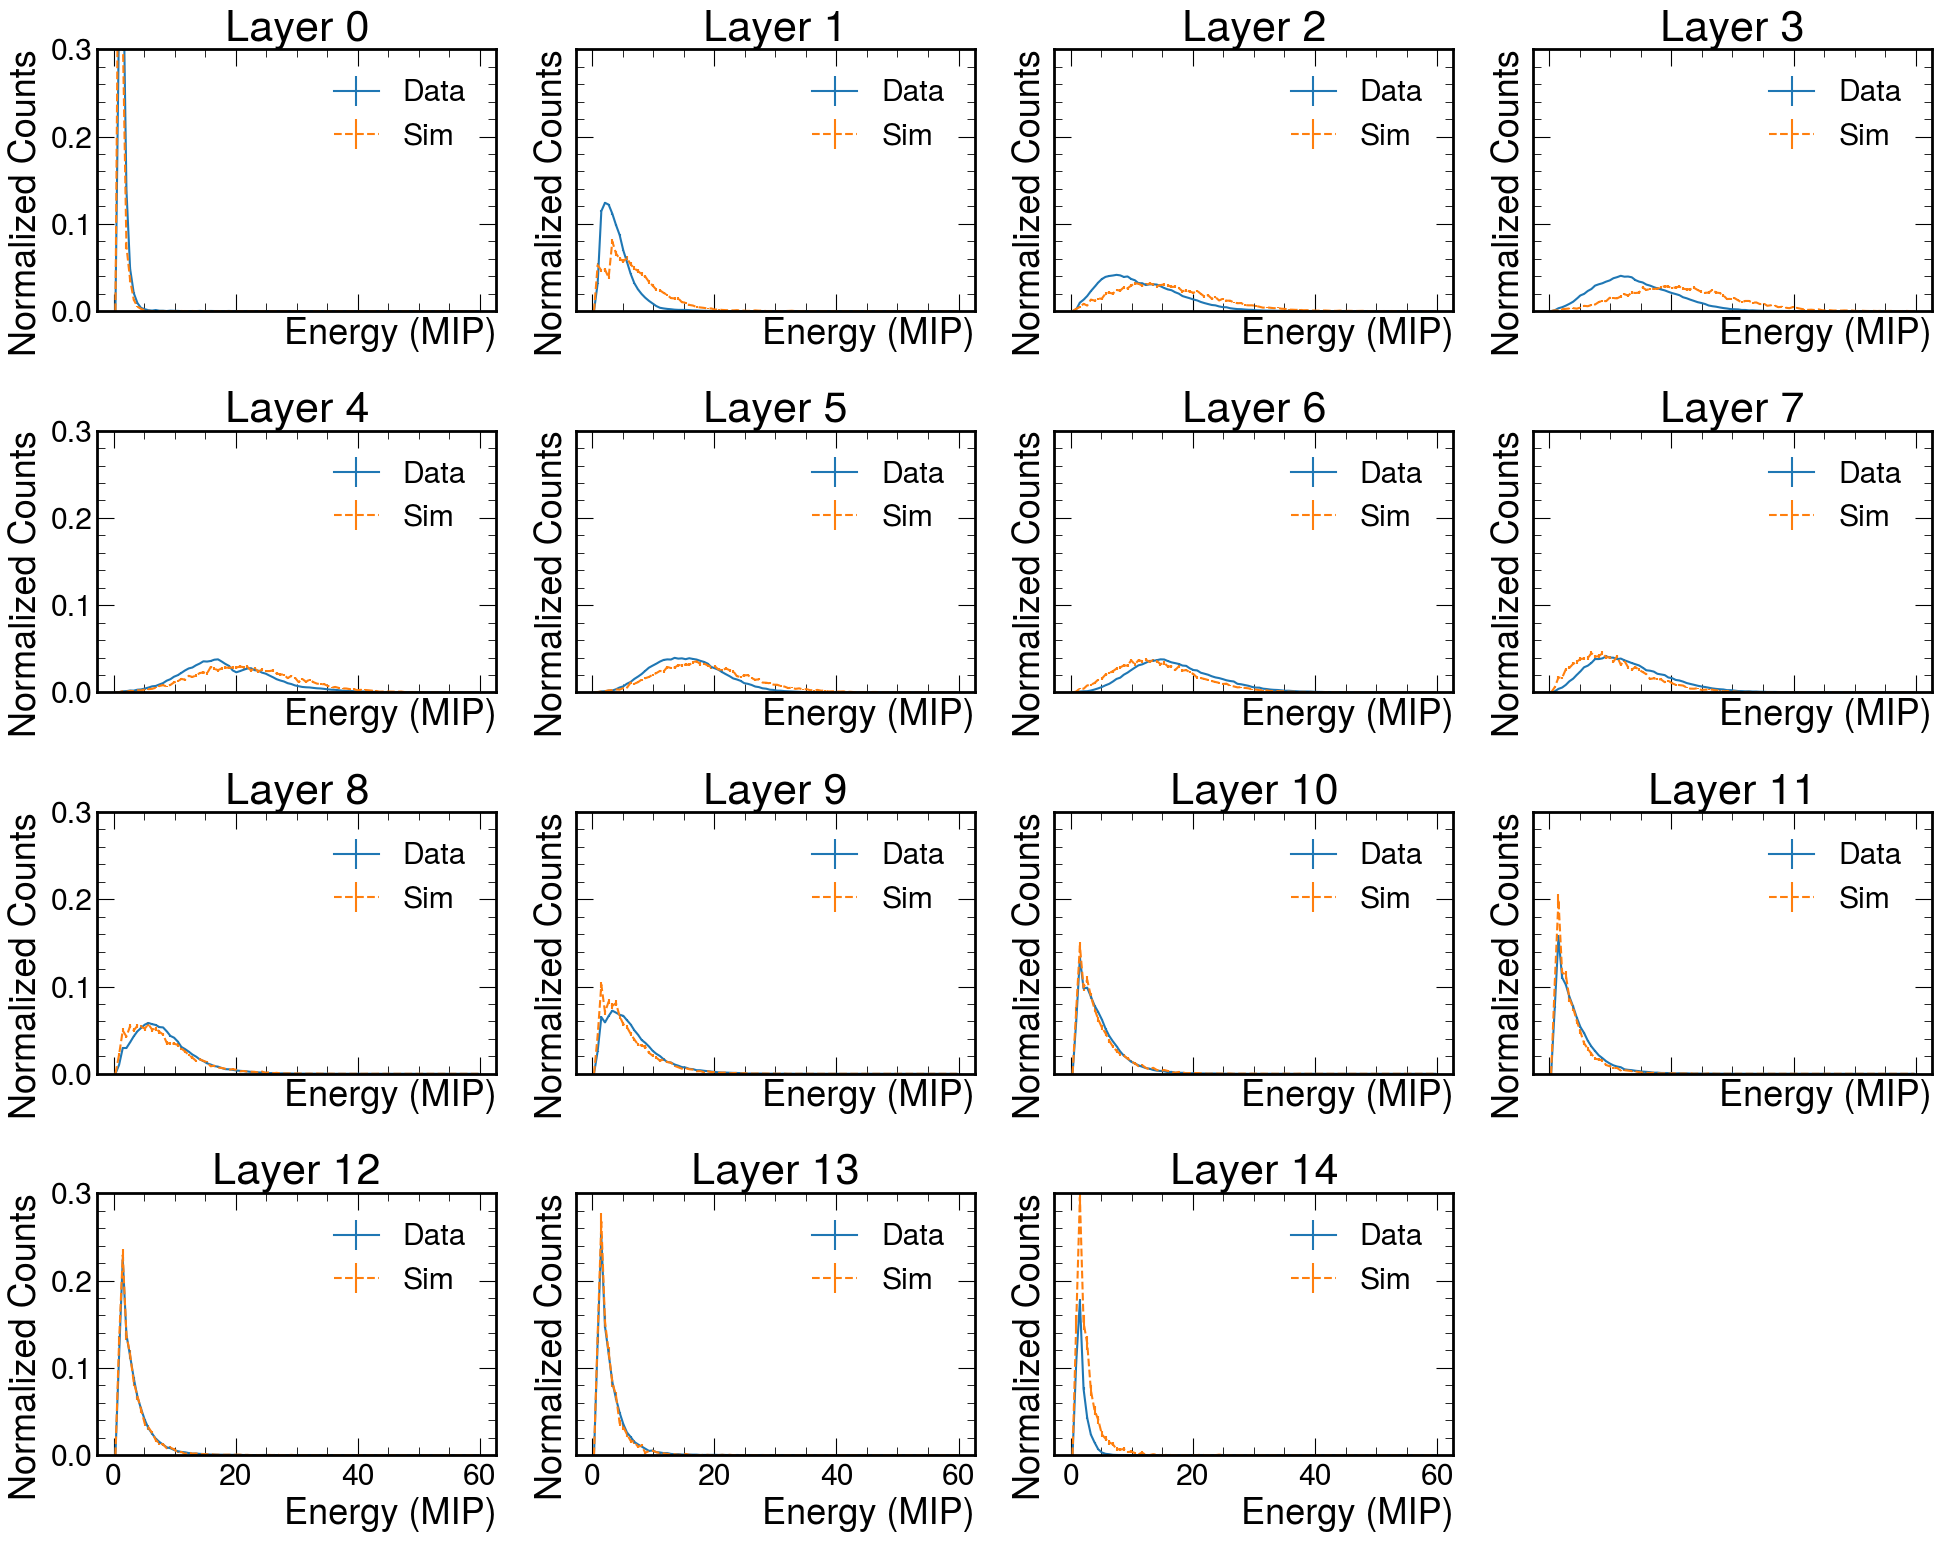

In [7]:
def plot_energy_histograms_comparison(data_df, sim_df, threshold, bins=100, hist_range=(0, 60)):
    # Drop NaNs and get sorted unique layers from the *data_df* only
    unique_layers = sorted(data_df['layer'].dropna().unique())
    n_layers = len(unique_layers)

    # Set up subplots
    ncols = 4
    nrows = int(np.ceil(n_layers / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, layer in enumerate(unique_layers):
        # Get event energy sums above threshold for both real and simulated data
        data_energy = layer_energy(data_df, layer, threshold)
        sim_energy = layer_energy(sim_df, layer, threshold)

        # Compute histograms
        data_counts, bin_edges = np.histogram(data_energy, bins=bins, range=hist_range)
        sim_counts, _ = np.histogram(sim_energy, bins=bin_edges)

        # Normalize by total counts (events)
        if data_counts.sum() > 0:
            data_norm = data_counts / len(data_energy)
            data_errors = np.sqrt(data_counts) / len(data_energy)
        else:
            data_norm = data_counts
            data_errors = data_counts

        if sim_counts.sum() > 0:
            sim_norm = sim_counts / len(sim_energy)
            sim_errors = np.sqrt(sim_counts) / len(sim_energy)
        else:
            sim_norm = sim_counts
            sim_errors = sim_counts

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        ax = axes[i]
        ax.errorbar(bin_centers, data_norm, yerr=data_errors, fmt='-', label='Data', color='tab:blue')
        ax.errorbar(bin_centers, sim_norm, yerr=sim_errors, fmt='--', label='Sim', color='tab:orange')

        ax.set_title(f'Layer {int(layer)}')
        ax.set_xlabel('Energy (MIP)')
        ax.set_ylabel('Normalized Counts')
        ax.set_ylim(0,0.3)
        ax.legend()

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.tight_layout()
    plt.show()

    
plot_energy_histograms_comparison(data_df=data_df, sim_df=sim_df, threshold=hit_threshold)

In [8]:
def event_cog(df, threshold):
    # Filter for hits above threshold and with finite x, y, z
    mask = (
        (df['energy_MIP'] > threshold) &
        df['x'].notna() & df['y'].notna() & df['z'].notna()
    )
    filtered = df[mask].copy()
    
    # Compute energy-weighted positions
    filtered['xw'] = filtered['x'] * filtered['energy_MIP']
    filtered['yw'] = filtered['y'] * filtered['energy_MIP']
    filtered['zw'] = filtered['z'] * filtered['energy_MIP']

    # Group by event and compute weighted average
    grouped = filtered.groupby('event').agg(
        x_cog = ('xw', lambda x: x.sum()),
        y_cog = ('yw', lambda x: x.sum()),
        z_cog = ('zw', lambda x: x.sum()),
        e_sum = ('energy_MIP', 'sum')
    )

    # Divide by total energy to get center of gravity
    grouped['x_cog'] /= grouped['e_sum']
    grouped['y_cog'] /= grouped['e_sum']
    grouped['z_cog'] /= grouped['e_sum']

    # Drop total energy column
    grouped = grouped.drop(columns=['e_sum']).reset_index()

    return grouped


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


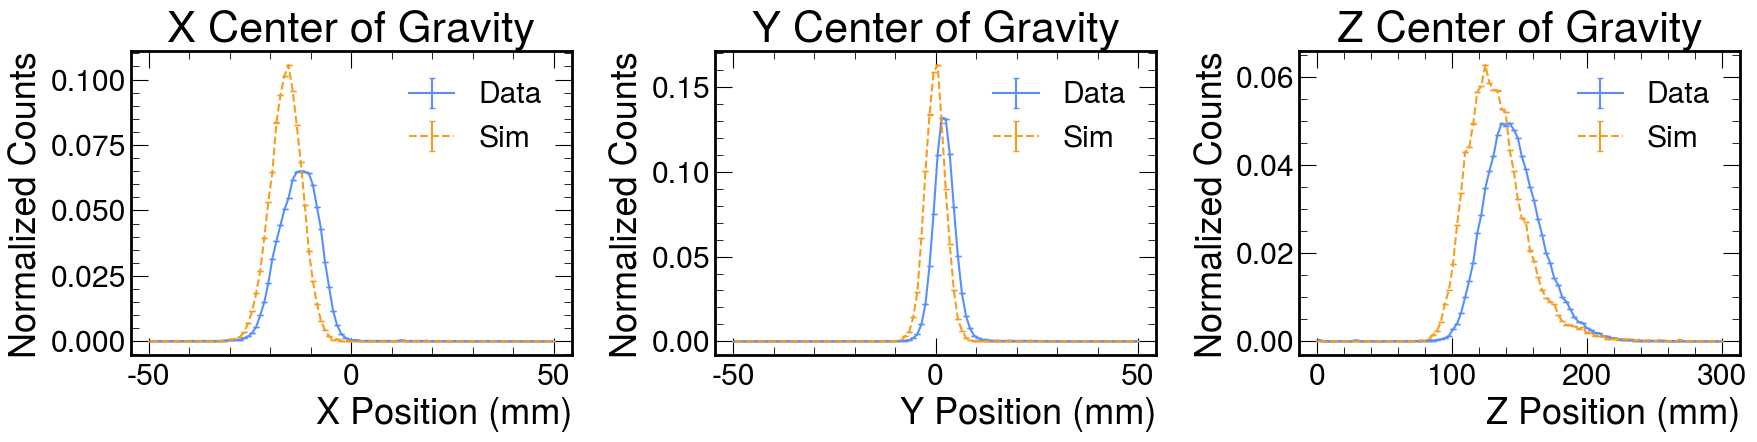

In [9]:
def plot_event_cog_distributions(data_df, sim_df, threshold=0.5, bins=100, ranges=None):
    """
    Plot x, y, z CoG histograms for data_df and sim_df side-by-side.

    Parameters:
        data_df (pd.DataFrame): Real data
        sim_df (pd.DataFrame): Simulated data
        threshold (float): Energy threshold to include hits
        bins (int): Number of bins per histogram
        ranges (dict or None): Optional bin ranges for x, y, z (keys: 'x', 'y', 'z')
    """
    # Get CoG data
    cog_data = event_cog(data_df, threshold)
    cog_sim = event_cog(sim_df, threshold)

    # Set default ranges if not given
    if ranges is None:
        ranges = {
            'x': (-50, 50),
            'y': (-50, 50),
            'z': (0,  300)
        }

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, coord in enumerate(['x_cog', 'y_cog', 'z_cog']):
        ax = axs[i]
        # Histogram real data
        counts_data, bins_data = np.histogram(cog_data[coord], bins=bins, range=ranges[coord[0]])
        bin_centers = (bins_data[:-1] + bins_data[1:]) / 2
        counts_data = counts_data / len(cog_data)  # normalize
        errors_data = np.sqrt(counts_data) / len(cog_data)

        # Histogram sim data
        counts_sim, bins_sim = np.histogram(cog_sim[coord], bins=bins, range=ranges[coord[0]])
        counts_sim = counts_sim / len(cog_sim)  # normalize
        errors_sim = np.sqrt(counts_sim) / len(cog_sim)

        # Plot
        ax.errorbar(bin_centers, counts_data, yerr=errors_data, label='Data', fmt='-', capsize=2)
        ax.errorbar(bin_centers, counts_sim, yerr=errors_sim, label='Sim', fmt='--', capsize=2)

        ax.set_title(f'{coord[0].upper()} Center of Gravity')
        ax.set_xlabel(f'{coord[0].upper()} Position (mm)')
        ax.set_ylabel('Normalized Counts')
        ax.legend()

    plt.tight_layout()
    plt.show()
    
plot_event_cog_distributions(data_df=data_df, sim_df=sim_df, threshold=hit_threshold)

In [10]:
def layer_xy_cog(df, layer_num, threshold):
    df_filtered = df[
        (df['layer'] == layer_num) &
        (df['energy_MIP'] > threshold) &
        df[['x', 'y']].notna().all(axis=1)
    ]
    
    def compute_cog(group):
        total_energy = group['energy_MIP'].sum()
        if total_energy == 0:
            return pd.Series({'x_cog': np.nan, 'y_cog': np.nan})
        x_cog = (group['x'] * group['energy_MIP']).sum() / total_energy
        y_cog = (group['y'] * group['energy_MIP']).sum() / total_energy
        return pd.Series({'x_cog': x_cog, 'y_cog': y_cog})

    return df_filtered.groupby('event').apply(compute_cog, include_groups=False)

0
1
2


/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_1332/775423924.py:12: RuntimeWarning: invalid value encountered in scalar divide
  x_cog = (group['x'] * group['energy_MIP']).sum() / total_energy
/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_1332/775423924.py:13: RuntimeWarning: invalid value encountered in scalar divide
  y_cog = (group['y'] * group['energy_MIP']).sum() / total_energy


3
4
5
6
7
8
9
10
11
12


/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_1332/775423924.py:12: RuntimeWarning: invalid value encountered in scalar divide
  x_cog = (group['x'] * group['energy_MIP']).sum() / total_energy
/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_1332/775423924.py:13: RuntimeWarning: invalid value encountered in scalar divide
  y_cog = (group['y'] * group['energy_MIP']).sum() / total_energy


13
14


/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_1332/775423924.py:12: RuntimeWarning: invalid value encountered in scalar divide
  x_cog = (group['x'] * group['energy_MIP']).sum() / total_energy
/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_1332/775423924.py:13: RuntimeWarning: invalid value encountered in scalar divide
  y_cog = (group['y'] * group['energy_MIP']).sum() / total_energy
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


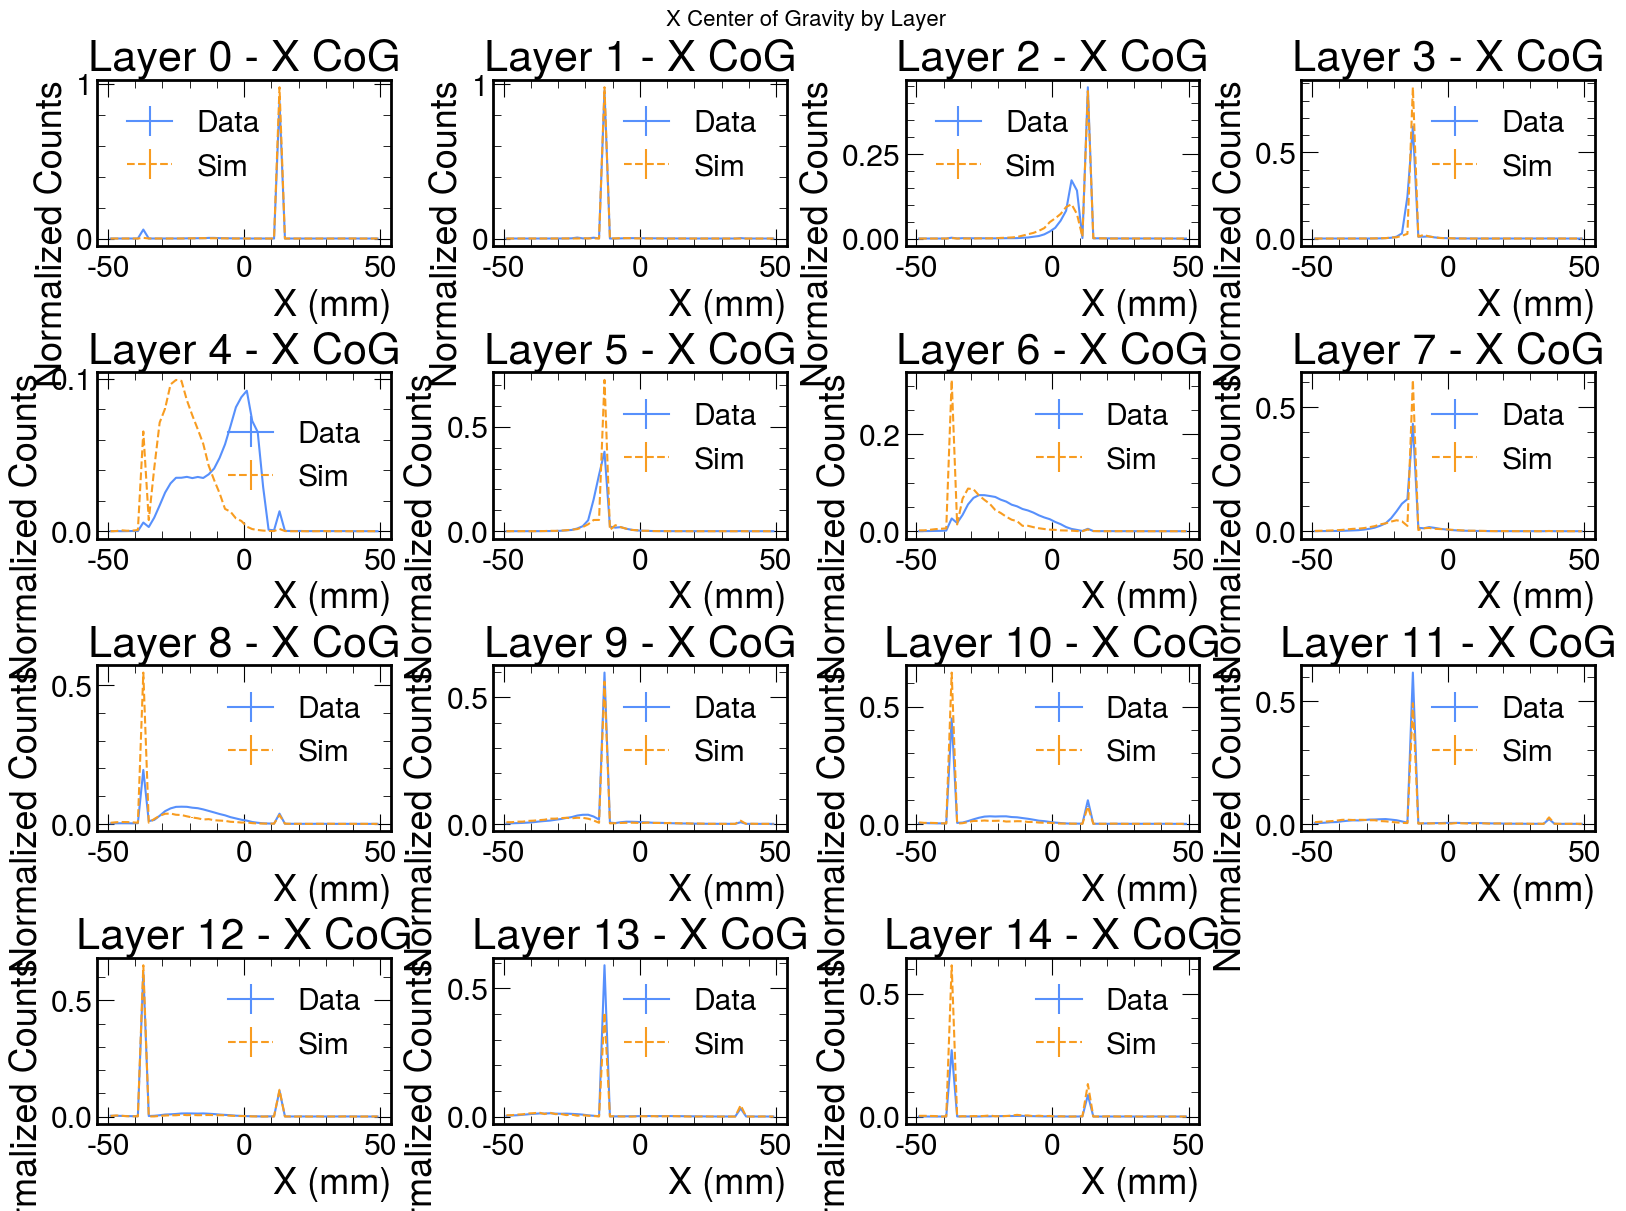

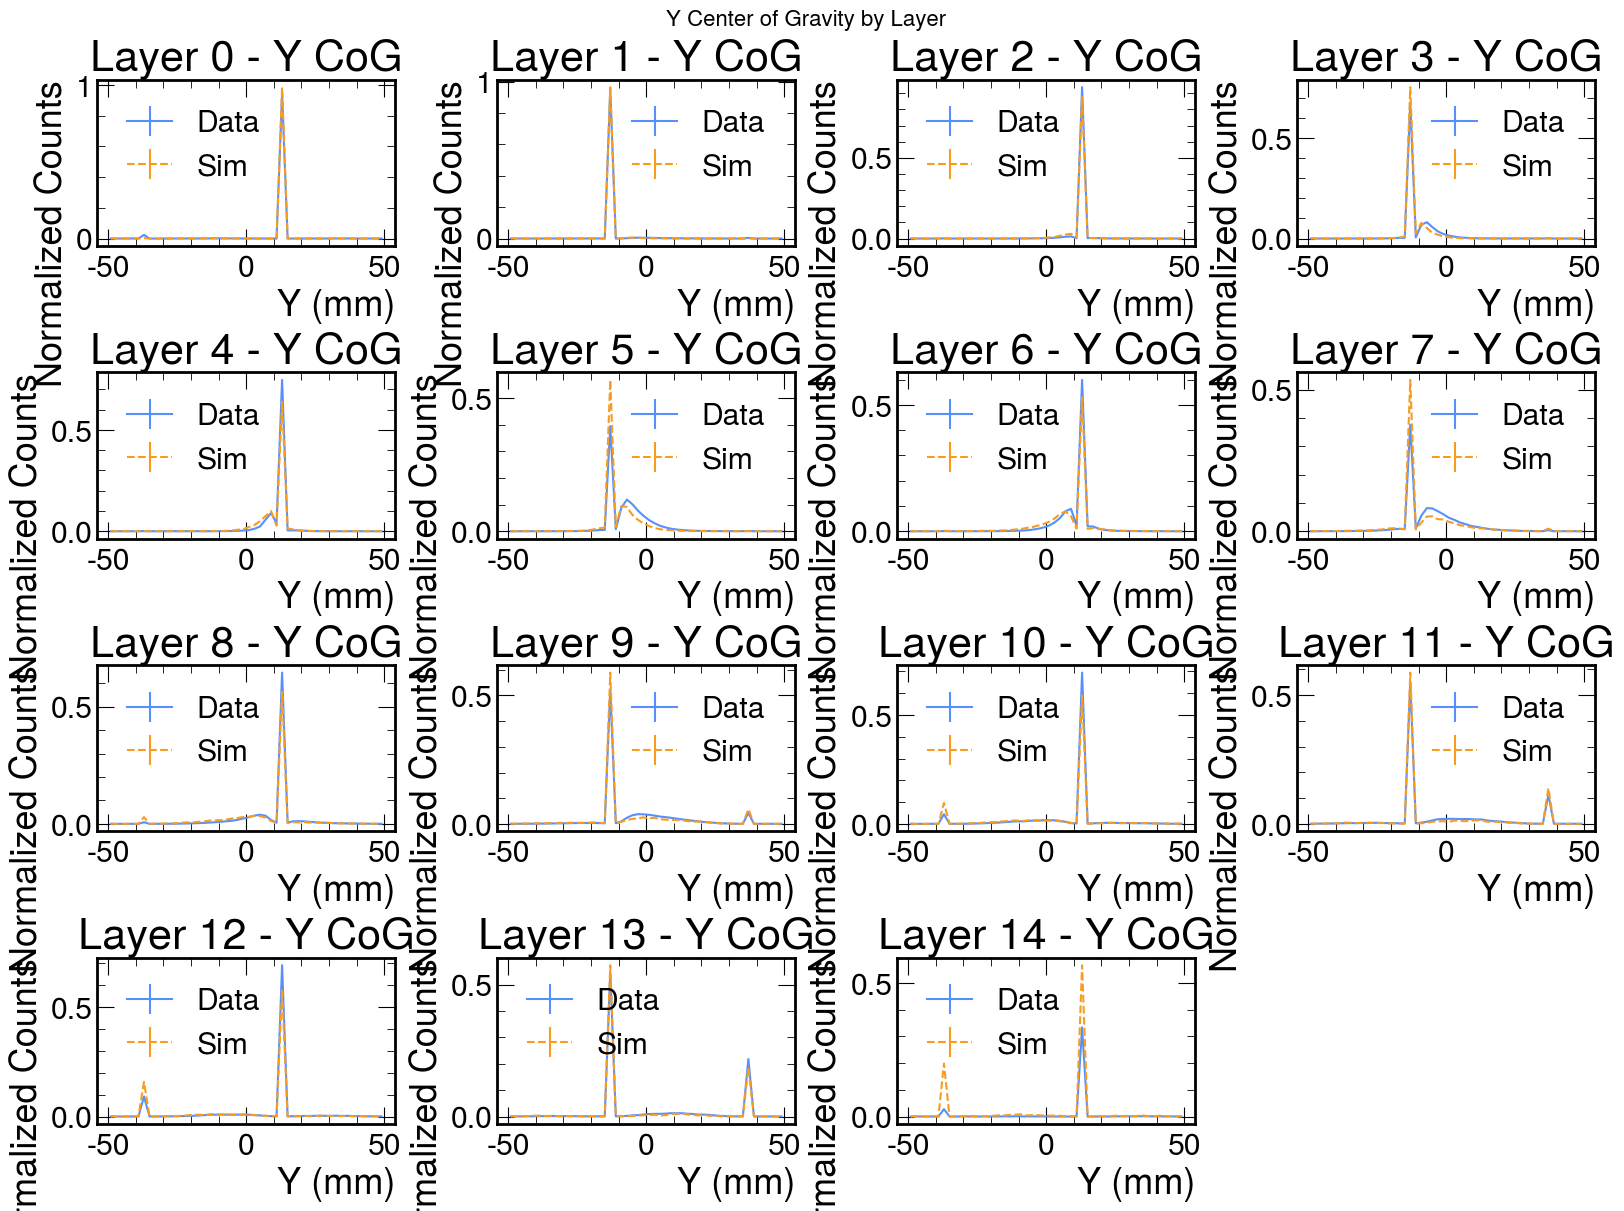

In [11]:
def plot_xy_cog_by_layer(data_df, sim_df, threshold=0.5, bins=50):
    layers = sorted(data_df['layer'].dropna().unique())
    num_layers = len(layers)
    ncols = 4
    nrows = (num_layers + ncols - 1) // ncols

    fig_x, axs_x = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), constrained_layout=True)
    fig_y, axs_y = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), constrained_layout=True)

    axs_x = axs_x.flatten()
    axs_y = axs_y.flatten()

    ranges = {
        'x': (-50, 50),
        'y': (-50, 50),
    }

    for i, layer in enumerate(layers):
        print(i)
        cog_data = layer_xy_cog(data_df, layer, threshold)
        cog_sim = layer_xy_cog(sim_df, layer, threshold)

        for coord, ax in zip(['x_cog', 'y_cog'], [axs_x[i], axs_y[i]]):
            if coord == 'x_cog':
                label = 'x'
            else:
                label = 'y'
                
            counts_data, bins_data = np.histogram(cog_data[coord], bins=bins, range=ranges[label])
            bin_centers = (bins_data[:-1] + bins_data[1:]) / 2
            counts_data = counts_data / len(cog_data)
            errors_data = np.sqrt(counts_data) / len(cog_data)

            counts_sim, bins_sim = np.histogram(cog_sim[coord], bins=bins, range=ranges[label])
            counts_sim = counts_sim / len(cog_sim)
            errors_sim = np.sqrt(counts_sim) / len(cog_sim)

            ax.errorbar(bin_centers, counts_data, yerr=errors_data, fmt='-', label='Data')
            ax.errorbar(bin_centers, counts_sim, yerr=errors_sim, fmt='--', label='Sim')
            ax.set_title(f'Layer {int(layer)} - {label.upper()} CoG')
            ax.set_xlabel(f'{label.upper()} (mm)')
            ax.set_ylabel('Normalized Counts')
            ax.legend()

    # Hide unused axes
    for j in range(i + 1, len(axs_x)):
        axs_x[j].axis('off')
        axs_y[j].axis('off')

    fig_x.suptitle('X Center of Gravity by Layer', fontsize=16)
    fig_y.suptitle('Y Center of Gravity by Layer', fontsize=16)

    plt.show()

plot_xy_cog_by_layer(data_df=data_df, sim_df=sim_df, threshold=hit_threshold)

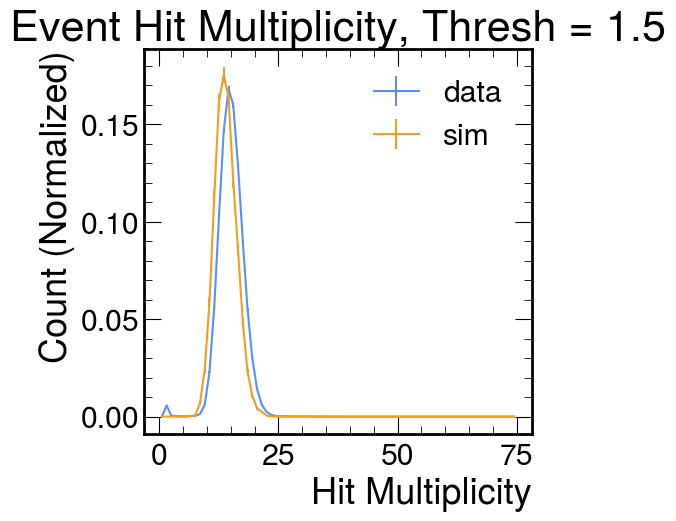

In [18]:
def event_hit_multiplicity(data_df, threshold=0.5):
    # Filter hits above the threshold
    filtered_df = data_df[data_df['energy_MIP'] > threshold]

    # Count hits per event
    multiplicity_series = filtered_df.groupby('event').size()

    # Return as NumPy array
    return multiplicity_series.values

hit_threshold = 2.0

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
evt_mult = event_hit_multiplicity(data_df, hit_threshold)
counts, bin_edges = np.histogram(evt_mult, bins=75, range=[0, 75])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
counts = counts / len(evt_mult)
errors = errors / len(evt_mult)
plt.errorbar(bin_centers, counts, yerr=errors, fmt='-', label="data")

evt_mult = event_hit_multiplicity(sim_df, hit_threshold)
counts, bin_edges = np.histogram(evt_mult, bins=75, range=[0, 75])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)
counts = counts / len(evt_mult)
errors = errors / len(evt_mult)
plt.errorbar(bin_centers, counts, yerr=errors, fmt='-',label="sim")
plt.title("Event Hit Multiplicity, Thresh = 1.5")
plt.xlabel("Hit Multiplicity")
plt.ylabel("Count (Normalized)")
plt.legend()
plt.show()

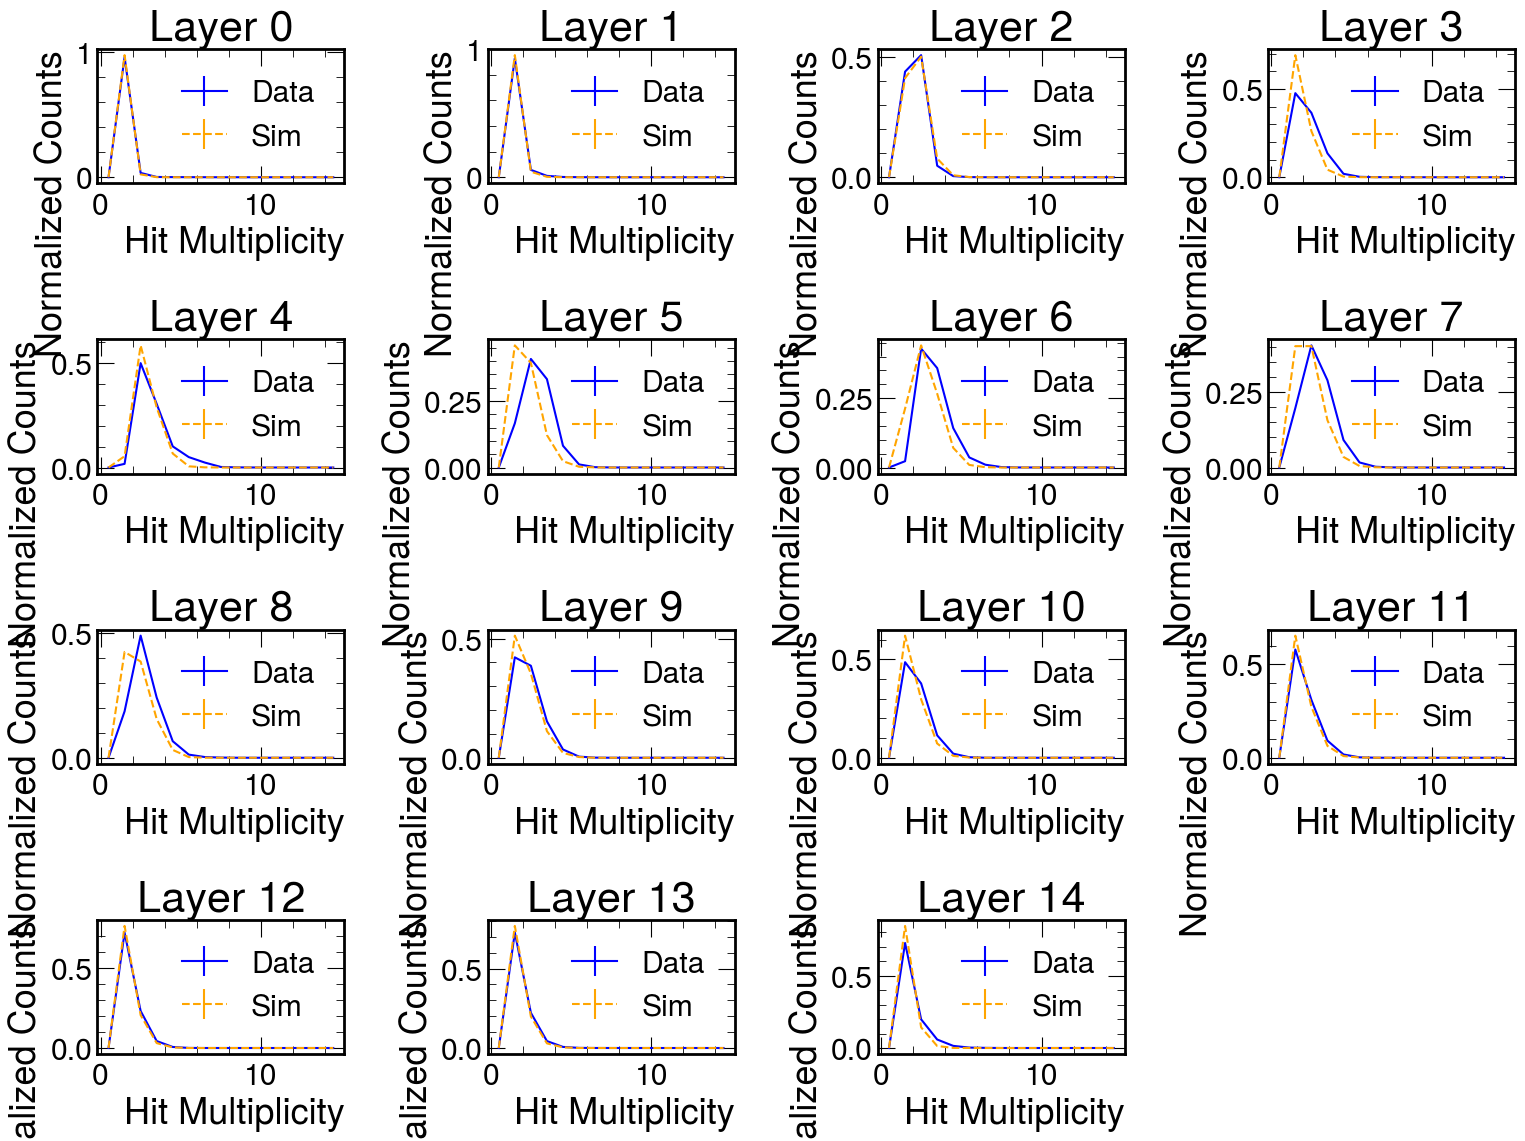

In [13]:
def layer_event_hit_multiplicity(data_df, layer, threshold=0.5):
    # Filter hits above the threshold and for the specified layer
    filtered_df = data_df[
        (data_df['energy_MIP'] > threshold) & 
        (data_df['layer'] == layer)
    ]

    # Count hits per event in that layer
    multiplicity_series = filtered_df.groupby('event').size()

    # Return as NumPy array
    return multiplicity_series.values

def plot_hit_multiplicity_by_layer(data_df, sim_df, threshold=0.5, bins=15, max_layers=None):
    # Identify valid (non-NaN) unique layers
    layers = sorted(data_df['layer'].dropna().unique())
    if max_layers:
        layers = layers[:max_layers]

    n_layers = len(layers)
    ncols = 4
    nrows = int(np.ceil(n_layers / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), tight_layout=True)

    for idx, layer in enumerate(layers):
        row, col = divmod(idx, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]

        # Get multiplicity arrays
        mult_data = layer_event_hit_multiplicity(data_df, layer, threshold)
        mult_sim = layer_event_hit_multiplicity(sim_df, layer, threshold)

        # Histogram data
        counts_data, bins_data = np.histogram(mult_data, bins=bins, range=(0, 15))
        counts_sim, bins_sim = np.histogram(mult_sim, bins=bins, range=(0, 15))

        # Normalize
        counts_data = counts_data / len(mult_data) if len(mult_data) > 0 else counts_data
        counts_sim = counts_sim / len(mult_sim) if len(mult_sim) > 0 else counts_sim

        bin_centers = (bins_data[:-1] + bins_data[1:]) / 2

        # Error bars
        errors_data = np.sqrt(counts_data) / len(mult_data) if len(mult_data) > 0 else np.zeros_like(counts_data)
        errors_sim = np.sqrt(counts_sim) / len(mult_sim) if len(mult_sim) > 0 else np.zeros_like(counts_sim)

        # Plot
        ax.errorbar(bin_centers, counts_data, yerr=errors_data, fmt='-', label='Data', color='blue')
        ax.errorbar(bin_centers, counts_sim, yerr=errors_sim, fmt='--', label='Sim', color='orange')
        ax.set_title(f'Layer {int(layer)}')
        ax.set_xlabel('Hit Multiplicity')
        ax.set_ylabel('Normalized Counts')
        ax.legend()

    # Hide any unused subplots
    for j in range(idx + 1, nrows * ncols):
        row, col = divmod(j, ncols)
        fig.delaxes(axes[row, col] if nrows > 1 else axes[col])

    plt.show()

plot_hit_multiplicity_by_layer(data_df=data_df, sim_df=sim_df, threshold=hit_threshold)


In [14]:
def compute_all_event_moment_matrices(data_df, e_cut=0.5):
    def compute_moment_matrix(group):
        energies = group['energy_MIP'].to_numpy(dtype=np.float32)
        positions = group[['x', 'y', 'z']].to_numpy(dtype=np.float32)

        mask = energies > e_cut
        if np.count_nonzero(mask) == 0:
            return np.full((3, 3), np.nan, dtype=np.float32)

        energies = energies[mask]
        positions = positions[mask]

        # Check for NaNs or infs in energies or positions
        if np.any(np.isnan(energies)) or np.any(np.isinf(energies)):
            # Debug print - remove or comment out after debugging

            return np.full((3, 3), np.nan, dtype=np.float32)

        if np.any(np.isnan(positions)) or np.any(np.isinf(positions)):

            return np.full((3, 3), np.nan, dtype=np.float32)

        energy_sum = energies.sum()
        if energy_sum <= 1e-10:
            return np.full((3, 3), np.nan, dtype=np.float32)

        # Explicit check before division
        if energy_sum == 0:
            return np.full((3, 3), np.nan, dtype=np.float32)

        weights = energies / energy_sum

        # Extra check: weights should not contain NaNs or infs
        if np.any(np.isnan(weights)) or np.any(np.isinf(weights)):
            return np.full((3, 3), np.nan, dtype=np.float32)

        if np.sum(weights) == 0:
            return np.full((3, 3), np.nan, dtype=np.float32)

        cog = np.average(positions, axis=0, weights=weights)
        deltas = positions - cog

        moment_matrix = np.einsum('i,ij,ik->jk', weights, deltas, deltas) / np.sum(weights)
        return moment_matrix

    return data_df.groupby('event', group_keys=False).apply(compute_moment_matrix)


In [15]:
def compute_all_cluster_orientations(moment_matrices):
    """
    Computes orientation information for a Series of 3x3 moment matrices.
    Ensures principal axis always points forward (z >= 0).

    Parameters:
        moment_matrices: pd.Series where each entry is a (3, 3) ndarray (moment matrix)

    Returns:
        pd.DataFrame with columns:
            - theta: angle from z-axis [0, π/2]
            - phi: angle in x-y plane
            - principal_axis_x, y, z: components of principal axis
            - eigenvalues: array of eigenvalues
    """
    results = []

    for event_id, matrix in moment_matrices.items():
        if matrix is None or np.isnan(matrix).any():
            results.append({
                'event': event_id,
                'theta': np.nan,
                'phi': np.nan,
                'principal_axis_x': np.nan,
                'principal_axis_y': np.nan,
                'principal_axis_z': np.nan,
                'eigenvalues': [np.nan, np.nan, np.nan]
            })
            continue

        try:
            eigenvalues, eigenvectors = np.linalg.eigh(matrix)
            principal_index = np.argmax(eigenvalues)
            principal_axis = eigenvectors[:, principal_index]
            principal_axis /= np.linalg.norm(principal_axis)

            # Flip axis to point forward in z
            if principal_axis[2] < 0:
                principal_axis = -principal_axis

            x, y, z = principal_axis
            theta = np.arccos(z)
            phi = np.arctan2(y, x)

            results.append({
                'event': event_id,
                'theta': theta,
                'phi': phi,
                'principal_axis_x': x,
                'principal_axis_y': y,
                'principal_axis_z': z,
                'eigenvalues': eigenvalues
            })
        except Exception:
            results.append({
                'event': event_id,
                'theta': np.nan,
                'phi': np.nan,
                'principal_axis_x': np.nan,
                'principal_axis_y': np.nan,
                'principal_axis_z': np.nan,
                'eigenvalues': [np.nan, np.nan, np.nan]
            })

    return pd.DataFrame(results).set_index('event')



In [16]:
moment_matrices_data = compute_all_event_moment_matrices(data_df, e_cut=hit_threshold)
moment_matrices_sim = compute_all_event_moment_matrices(sim_df, e_cut=hit_threshold)
orient_data = compute_all_cluster_orientations(moment_matrices_data)
orient_sim = compute_all_cluster_orientations(moment_matrices_sim)

/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_1332/1095741931.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data_df.groupby('event', group_keys=False).apply(compute_moment_matrix)
/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_1332/1095741931.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data_df.groupby('event', group_keys=False).apply(compute_moment_matr

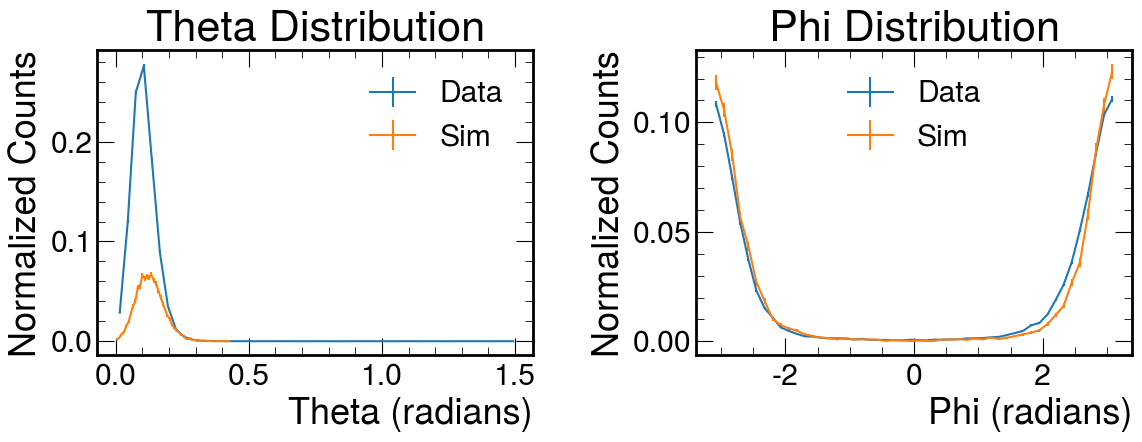

In [17]:
def plot_theta_phi_distributions(orient_data, orient_sim, bins_theta=50, bins_phi=50):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    coords = ['theta', 'phi']
    bins_dict = {'theta': bins_theta, 'phi': bins_phi}
    colors = {'data': 'tab:blue', 'sim': 'tab:orange'}
    
    for i, coord in enumerate(coords):
        for label, orient_df in zip(['data', 'sim'], [orient_data, orient_sim]):
            values = orient_df[coord].dropna().values
            n_events = len(values)

            if n_events == 0:
                continue

            counts, bin_edges = np.histogram(values, bins=bins_dict[coord], range=(values.min(), values.max()))
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

            norm_counts = counts / n_events
            norm_errors = np.sqrt(counts) / n_events

            axes[i].errorbar(bin_centers, norm_counts, yerr=norm_errors, fmt='-', label=label.capitalize(), color=colors[label])
        
        axes[i].set_title(f'{coord.capitalize()} Distribution')
        axes[i].set_xlabel(f'{coord.capitalize()} (radians)')
        axes[i].set_ylabel('Normalized Counts')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_theta_phi_distributions(orient_data, orient_sim)

In [18]:
def project_to_z0(cog_df, orient_df):
    """
    Given dataframes with cluster COG and principal axis,
    compute projected (x, y) at z=0 plane for each event.
    
    Parameters:
        cog_df: DataFrame with columns ['event', 'x_cog', 'y_cog', 'z_cog']
        orient_df: DataFrame with columns ['event', 'principal_axis_x', 'principal_axis_y', 'principal_axis_z']
    
    Returns:
        DataFrame with columns ['event', 'x_proj', 'y_proj'] representing intersection point at z=0
    """
    merged = cog_df.merge(orient_df, on='event')

    def compute_projection(row):
        z0 = row['z_cog']
        vz = row['principal_axis_z']
        if vz == 0:
            # Avoid division by zero, no intersection if principal axis parallel to plane
            return pd.Series({'x_proj': np.nan, 'y_proj': np.nan})
        
        t = -z0 / vz
        x_proj = row['x_cog'] + t * row['principal_axis_x']
        y_proj = row['y_cog'] + t * row['principal_axis_y']
        return pd.Series({'x_proj': x_proj, 'y_proj': y_proj})
    
    proj_points = merged.apply(compute_projection, axis=1)
    result = pd.concat([merged['event'], proj_points], axis=1)
    return result


In [19]:
cog_data = event_cog(data_df, hit_threshold)
cog_sim = event_cog(sim_df, hit_threshold)

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


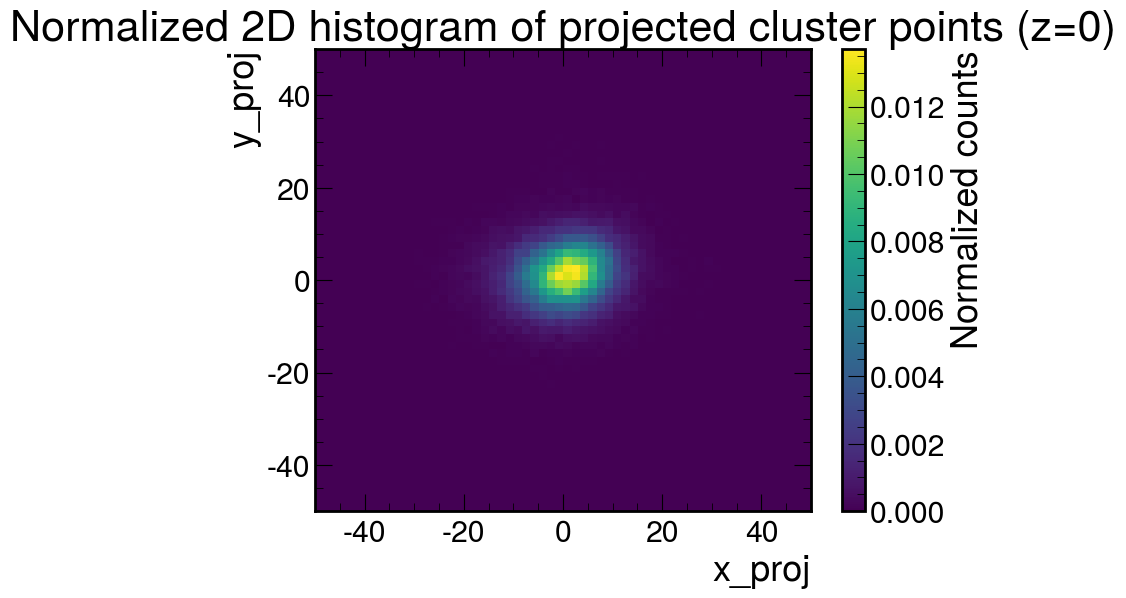

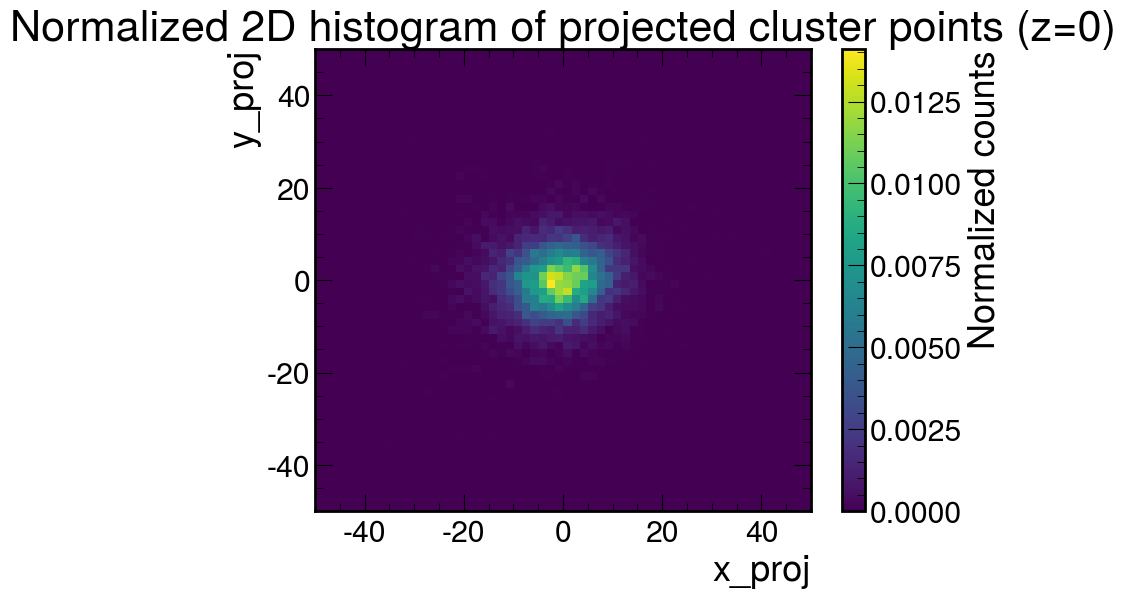

In [20]:
def plot_projected_2d_hist(proj_df, bins=50, range_x=None, range_y=None):
    """
    Plot normalized 2D histogram with error bars of projected (x_proj, y_proj).
    
    Parameters:
        proj_df: DataFrame with columns ['x_proj', 'y_proj']
        bins: int or [int, int], number of bins for x and y
        range_x: tuple (xmin, xmax) or None
        range_y: tuple (ymin, ymax) or None
    """
    x = proj_df['x_proj'].values
    y = proj_df['y_proj'].values
    
    # Remove NaNs
    mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    # Compute 2D histogram
    counts, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[range_x, range_y])
    
    # Normalize by total counts
    total = counts.sum()
    if total > 0:
        counts_norm = counts / total
        errors = np.sqrt(counts) / total
    else:
        counts_norm = counts
        errors = np.zeros_like(counts)
    
    # Compute bin centers
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    
    # Plot with imshow and overlay error as contour or colorbar
    
    plt.figure(figsize=(8,6))
    im = plt.imshow(
        counts_norm.T, origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        aspect='auto',
        cmap='viridis'
    )
    plt.colorbar(im, label='Normalized counts')
    plt.xlabel('x_proj')
    plt.ylabel('y_proj')
    plt.title('Normalized 2D histogram of projected cluster points (z=0)')
    plt.show()

proj_points_data = project_to_z0(cog_data, orient_data)
plot_projected_2d_hist(proj_points_data, bins=60, range_x=(-50,50), range_y=(-50,50))

proj_points_sim = project_to_z0(cog_sim, orient_sim)
plot_projected_2d_hist(proj_points_sim, bins=60, range_x=(-50,50), range_y=(-50,50))
